# Capstone Project
Diane Kierce  
General Assembly  
DSI Seattle 02


### #covfefe: Finding Meaning in Usage

#### In this notebook:
This notebook contains the code I used to extract the hashtags from each tweet, construct a vector count matrix, and perform LDA modeling to determine the number of meaningful topics contained within them.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from itertools import chain
from collections import defaultdict
from gensim import corpora, models, matutils
from wordcloud import WordCloud
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [2]:
df = pd.read_csv('./datasets/covfefe_hashtag_api_tweets.csv', sep=',', encoding='utf-8', index_col=None)
df = df[df['user_lang'] == 'en']

/Applications/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,13,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.shape

(54473, 18)

In [4]:
df.head()

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name
0,0,Fri Jun 16 13:13:32 +0000 2017,1336,"[{""text"": ""trump""}, {""text"": ""maga""}, {""text"":...",NaN,2017-06-17 22:45:08.039302,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",899,AMERICA AGREES! Gohmert: There Is No Collusion...,875702885572595712,"[{""expanded_url"": ""http://waynedupree.com/gohm...",192275.0,9517.0,🎙Wayne Dupree,2.826952e+08,en,USAF Desert Storm/Shield Vet,WayneDupreeShow
1,1,Fri Jun 16 16:53:35 +0000 2017,389,"[{""text"": ""covfefe""}, {""text"": ""trump""}]",NaN,2017-06-17 22:45:08.039313,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",271,JUST FIRE MUELLER! Deputy AG Just Dropped Warn...,875758262959960068,"[{""expanded_url"": ""http://waynedupree.com/depu...",192275.0,9517.0,🎙Wayne Dupree,2.826952e+08,en,USAF Desert Storm/Shield Vet,WayneDupreeShow
2,2,Fri Jun 16 16:25:06 +0000 2017,497,"[{""text"": ""AmericaFirst""}, {""text"": ""covfefe""}...",NaN,2017-06-17 22:45:08.039318,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",281,#AmericaFirst - Obama's Anchor Baby Program (D...,875751095414521858,"[{""expanded_url"": ""http://waynedupree.com/trum...",192275.0,9517.0,🎙Wayne Dupree,2.826952e+08,en,USAF Desert Storm/Shield Vet,WayneDupreeShow
3,3,Fri Jun 16 23:59:46 +0000 2017,0,"[{""text"": ""AmericaFirst""}, {""text"": ""covfefe""}...",NaN,2017-06-17 22:45:08.039322,"<a href=""http://twitter.com/download/iphone"" r...",281,RT @WayneDupreeShow: #AmericaFirst - Obama's A...,875865514626646016,"[{""expanded_url"": ""http://waynedupree.com/trum...",3268.0,4999.0,Crystal kemp,2.481855e+09,en,"Pennsylvania, USA",ckemp1542400
4,4,Fri Jun 16 23:59:17 +0000 2017,0,"[{""text"": ""CNNisISIS""}, {""text"": ""AlBaghdadi""}...","[{""display_url"": ""pic.twitter.com/U5Wg4g1Ird"",...",2017-06-17 22:45:08.039326,"<a href=""http://twitter.com/download/iphone"" r...",4,RT @politstrip: 'Caliphate News Network' mourn...,875865396045389825,[],110.0,85.0,Elizabeth Wright,3.707893e+09,en,NaN,ErwrightWright


In [5]:
df['hashtags'][0]

u'[{"text": "trump"}, {"text": "maga"}, {"text": "covfefe"}]'

In [6]:
# It's a string, so I need to split it on the "s to get the actual hashtags
tags = df['hashtags'][0].split('"')

tags

[u'[{',
 u'text',
 u': ',
 u'trump',
 u'}, {',
 u'text',
 u': ',
 u'maga',
 u'}, {',
 u'text',
 u': ',
 u'covfefe',
 u'}]']

In [7]:
# figuring out how to extract the hashtags
tags_list = [str(tags[4*x+3]) for x in range((len(tags)-1)/4)]

tags_list

['trump', 'maga', 'covfefe']

In [8]:
tags_column = [x.split('"') for x in df['hashtags']]

tags_column[1]

[u'[{', u'text', u': ', u'covfefe', u'}, {', u'text', u': ', u'trump', u'}]']

In [9]:
df['hashtags_clean'] = [[str(tags[4*x+3]).lower() for x in range((len(tags)-1)/4)] for tags in tags_column]

df.head()

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name,hashtags_clean
0,0,Fri Jun 16 13:13:32 +0000 2017,1336,"[{""text"": ""trump""}, {""text"": ""maga""}, {""text"":...",NaN,2017-06-17 22:45:08.039302,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",899,AMERICA AGREES! Gohmert: There Is No Collusion...,875702885572595712,"[{""expanded_url"": ""http://waynedupree.com/gohm...",192275.0,9517.0,🎙Wayne Dupree,2.826952e+08,en,USAF Desert Storm/Shield Vet,WayneDupreeShow,"[trump, maga, covfefe]"
1,1,Fri Jun 16 16:53:35 +0000 2017,389,"[{""text"": ""covfefe""}, {""text"": ""trump""}]",NaN,2017-06-17 22:45:08.039313,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",271,JUST FIRE MUELLER! Deputy AG Just Dropped Warn...,875758262959960068,"[{""expanded_url"": ""http://waynedupree.com/depu...",192275.0,9517.0,🎙Wayne Dupree,2.826952e+08,en,USAF Desert Storm/Shield Vet,WayneDupreeShow,"[covfefe, trump]"
2,2,Fri Jun 16 16:25:06 +0000 2017,497,"[{""text"": ""AmericaFirst""}, {""text"": ""covfefe""}...",NaN,2017-06-17 22:45:08.039318,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",281,#AmericaFirst - Obama's Anchor Baby Program (D...,875751095414521858,"[{""expanded_url"": ""http://waynedupree.com/trum...",192275.0,9517.0,🎙Wayne Dupree,2.826952e+08,en,USAF Desert Storm/Shield Vet,WayneDupreeShow,"[americafirst, covfefe, trump]"
3,3,Fri Jun 16 23:59:46 +0000 2017,0,"[{""text"": ""AmericaFirst""}, {""text"": ""covfefe""}...",NaN,2017-06-17 22:45:08.039322,"<a href=""http://twitter.com/download/iphone"" r...",281,RT @WayneDupreeShow: #AmericaFirst - Obama's A...,875865514626646016,"[{""expanded_url"": ""http://waynedupree.com/trum...",3268.0,4999.0,Crystal kemp,2.481855e+09,en,"Pennsylvania, USA",ckemp1542400,"[americafirst, covfefe, trump]"
4,4,Fri Jun 16 23:59:17 +0000 2017,0,"[{""text"": ""CNNisISIS""}, {""text"": ""AlBaghdadi""}...","[{""display_url"": ""pic.twitter.com/U5Wg4g1Ird"",...",2017-06-17 22:45:08.039326,"<a href=""http://twitter.com/download/iphone"" r...",4,RT @politstrip: 'Caliphate News Network' mourn...,875865396045389825,[],110.0,85.0,Elizabeth Wright,3.707893e+09,en,NaN,ErwrightWright,"[cnnisisis, albaghdadi, covfefe, maga]"


In [10]:
df['hashtag_string'] = [str(' '.join(x)) for x in df['hashtags_clean']]

In [11]:
# looking for rows that do not have 'covfefe' exactly as a hashtag
df_no_covfefe = df[df['hashtags_clean'].map(lambda x: 'covfefe' not in x)]

df_no_covfefe.shape

(1931, 20)

In [12]:
print(df_no_covfefe['hashtags_clean']) 

# This captured hashtags such as "covfefeact," which I would like to keep.

48                       [comey, muellerleaks, trumprussia]
80        [susanrice, buildthatwall, deepstate, justice4...
93                                                       []
242                                                      []
258                                                      []
312                                                      []
326       [usa, america, twitter, facebook, libtards, de...
331                                                      []
360                                                      []
367       [susanrice, buildthatwall, deepstate, justice4...
452       [theresistance, demforce, impeachtrump, impeac...
465                                                      []
470                                                      []
501                                                      []
516                                                      []
551       [corrupt, trumpempire, donaldtrump, trumpgate,...
589                                     

In [13]:
# Instead check the 'hashtag_string' column.

df_no_covfefe = df[df['hashtag_string'].map(lambda x: 'covfefe' not in x)]

df_no_covfefe.shape

(1922, 20)

In [14]:
print(df_no_covfefe['hashtag_string'])

48                           comey muellerleaks trumprussia
80        susanrice buildthatwall deepstate justice4seth...
93                                                         
242                                                        
258                                                        
312                                                        
326       usa america twitter facebook libtards dems dnc...
331                                                        
360                                                        
367       susanrice buildthatwall deepstate justice4seth...
452           theresistance demforce impeachtrump impeach45
465                                                        
470                                                        
501                                                        
516                                                        
551       corrupt trumpempire donaldtrump trumpgate ivan...
589                                     

In [15]:
# These can be deleted.

df.drop(df_no_covfefe.index, inplace=True, axis=0)

df.shape

(52551, 20)

In [16]:
messy_hashtags = df[df['hashtag_string'].map(lambda x: '\\u' in x)]

In [17]:
messy_hashtags

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name,hashtags_clean,hashtag_string
281,281,Fri Jun 16 22:48:41 +0000 2017,1,"[{""text"": ""covfefe""}, {""text"": ""peg\u00f3n""}]",NaN,2017-06-17 22:45:09.655699,"<a href=""http://twitter.com/download/iphone"" r...",0,tal vez #covfefe era el #pegón de donaltromp.,875847625798496256,[],413.0,213.0,Carlos Arias López,2.609872e+08,en,Panamá,cariaslopez,"[covfefe, peg\u00f3n]",covfefe peg\u00f3n
418,418,Fri Jun 16 22:13:38 +0000 2017,0,"[{""text"": ""\u0627\u0644\u064a\u0648\u0643\u064...",NaN,2017-06-17 22:45:10.182109,"<a href=""http://twitter.com/download/iphone"" r...",0,#اليوكن_الأسود\n#Covfefe,875838808574623744,[],493.0,259.0,Omar Almutairi,2.546030e+08,en,NaN,OmarAlabdali,[\u0627\u0644\u064a\u0648\u0643\u0646_\u0627\u...,\u0627\u0644\u064a\u0648\u0643\u0646_\u0627\u0...
1926,1926,Fri Jun 16 14:28:17 +0000 2017,0,"[{""text"": ""Covfefe""}, {""text"": ""\u0161trumpvfe...","[{""display_url"": ""pic.twitter.com/jbCApsKA5u"",...",2017-06-17 22:45:22.186379,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,#Covfefe #štrumpvfefe https://t.co/jbCApsKA5u,875721699697848321,[],829.0,2450.0,Tina,9.395012e+08,en,"Krk , Croatia",MartinaRimbaldo,"[covfefe, \u0161trumpvfefe]",covfefe \u0161trumpvfefe
2822,2822,Fri Jun 16 09:13:16 +0000 2017,0,"[{""text"": ""\u062a\u06cc\u0644\u0631\u0633\u064...",NaN,2017-06-17 22:45:29.298315,"<a href=""http://twitter.com/download/android"" ...",7,RT @HamedShojaie: آقای #تیلرسون! اگر خیلی راست...,875642420339200002,[],25.0,45.0,saeed fatemi,4.954914e+07,en,"iran, mashhad",saeedasack,"[\u062a\u06cc\u0644\u0631\u0633\u0648\u0646, c...",\u062a\u06cc\u0644\u0631\u0633\u0648\u0646 cov...
4032,4030,Fri Jun 16 01:40:38 +0000 2017,0,"[{""text"": ""\u0639\u0644\u064a_\u0646\u062c\u06...","[{""display_url"": ""pic.twitter.com/eGGVLGPbIq"",...",2017-06-17 22:45:37.893681,"<a href=""http://twitter.com/download/iphone"" r...",2,RT @missdodo063: اعطي لدرجة ما يبقى ما يعطى له...,875528513603985410,[],344.0,189.0,عبير بنت أحمد,7.174529e+17,en,..,Alda3yhh,"[\u0639\u0644\u064a_\u0646\u062c\u0645, covfef...",\u0639\u0644\u064a_\u0646\u062c\u0645 covfefe ...
5069,5067,Thu Jun 15 21:50:24 +0000 2017,0,"[{""text"": ""\u062a\u06cc\u0644\u0631\u0633\u064...",NaN,2017-06-17 22:45:44.339339,"<a href=""http://twitter.com/download/iphone"" r...",7,RT @HamedShojaie: آقای #تیلرسون! اگر خیلی راست...,875470571701776386,[],101.0,175.0,Soheil,8.580353e+17,en,NaN,s_poorghafar,"[\u062a\u06cc\u0644\u0631\u0633\u0648\u0646, c...",\u062a\u06cc\u0644\u0631\u0633\u0648\u0646 cov...
5209,5207,Thu Jun 15 21:21:46 +0000 2017,0,"[{""text"": ""\u062a\u06cc\u0644\u0631\u0633\u064...",NaN,2017-06-17 22:45:45.542117,"<a href=""http://twitter.com/download/android"" ...",7,RT @HamedShojaie: آقای #تیلرسون! اگر خیلی راست...,875463364708794370,[],632.0,335.0,راوی,1.864214e+09,en,همینجا,dayeeamin,"[\u062a\u06cc\u0644\u0631\u0633\u0648\u0646, c...",\u062a\u06cc\u0644\u0631\u0633\u0648\u0646 cov...
5284,5282,Thu Jun 15 21:01:44 +0000 2017,0,"[{""text"": ""\u062a\u06cc\u0644\u0631\u0633\u064...",NaN,2017-06-17 22:45:46.141268,"<a href=""http://twitter.com/download/iphone"" r...",7,RT @HamedShojaie: آقای #تیلرسون! اگر خیلی راست...,875458323453181954,[],718.0,1926.0,Alireza Kanji,8.706070e+17,en,NaN,AlirezaKanji,"[\u062a\u06cc\u0644\u0631\u0633\u0648\u0646, c...",\u062a\u06cc\u0644\u0631\u0633\u0648\u0646 cov...
5329,5327,Thu Jun 15 20:52:31 +0000 2017,0,"[{""text"": ""\u062a\u06cc\u0644\u0631\u0633\u064...",NaN,2017-06-17 22:45:46.850347,"<a href=""http://twitter.com/download/iphone"" r...",7,RT @HamedShojaie: آقای #تیلرسون! اگر خیلی راست...,875456005634760704,[],1112.0,400.0,masiesmaili 🇮🇷,1.148914e+09,en,NaN,masietwitt,"[\u062a\u06cc\u0644\u0631\u0633\u0648\u0646, c...",\u062a\u06cc\u0644\u0631\u0633\u0648\u0646 cov...
5348,5346,Thu Jun 15 20:49:04

In [18]:
messy_hashtags.shape

(66, 20)

In [19]:
# dropping these rows to make topic modeling cleaner without the non-Roman alphabet characters
df.drop(messy_hashtags.index, inplace=True, axis=0)

df.shape

(52485, 20)

In [20]:
retweets = df[df['text'].map(lambda x: 'RT' in x)]

retweets.shape

(35173, 20)

In [21]:
retweets['text'].value_counts()

RT @Publius_Philo: Senator, I know what "hope" means to @realDonaldTrump-It is #covfefe I don't understand. #cnn #foxnews #JamesComey #Russ…                          1690
RT @kwilli1046: Loretta Lynch calling for marching, blood, death in the streets   \nto oppose Pres Trump\n#covfefe https://t.co/yVeg17qtol                            1619
RT @ConstanceQueen8: Don't know who created \nAcronym but I'm a fan\n#ComeyHearing #Covfefe https://t.co/rQ3qqlw8Dg                                                   1425
RT @WayneDupreeShow: Congress needs to seek out #LorettaLynch immediately! #covfefe #trump #realtalk https://t.co/s301hXrhiO                                          1114
RT @vitalii: @MKBHD I suggest Retweet if you'd want this to happen before we walk on Mars! #EditTweets #covfefe https://t.co/vvkdMBVNp6                                958
RT @WayneDupreeShow: Did you know FB permanently banned a Pro-Trump FB Group with over 130K members? https://t.co/fcdqioqho7 #covfefe #trum…     

In [22]:
no_retweets = df[df['text'].map(lambda x: 'RT' not in x)]

no_retweets.shape

(17312, 20)

In [23]:
# Formatting the text so that I can make a word cloud
text = " ".join(no_retweets['hashtag_string'])

In [24]:
text

'trump maga covfefe covfefe trump americafirst covfefe trump covfefe island areyoukidding smh covfefe covfefe covfefe potus maga cnnisisis albaghdadi covfefe maga alternativefacts covfefe covfefeyourself fakenews covfefe cnn foxnews rueters covfefe covfefe covfefe tcot covfefe covfefe maga trump covfefe grammarrules gradingtrump covfefe imsorrytobotheryou covfefe covfefe covfefe covfefe cheetohitler summerreading covfefe covfefe trump maga covfefe tcot covfefe snl spicerfacts maga covfefe covfefe covfefe legislation accountability transparency maga covfefe imsorrytobotheryou covfefe ps4 covfefe covfefe maga covfefe covfefe covfefe covfefe covfefe science chemistry periodictable covfefe maga cuck nevertrumper covfefe maga trump covfefe covfefe trump maga spicerfacts maga covfefe covfefe msm fakenews covfefe covfefe covfefe maga resist loltrump covfefe dailyshowlibrary covfefe obama trump bigly covfefe covfefe covfefe whenwerunoutofhashtags covfefe covfefe covfefe covfefe trumpsarmy covf

(-0.5, 799.5, 399.5, -0.5)

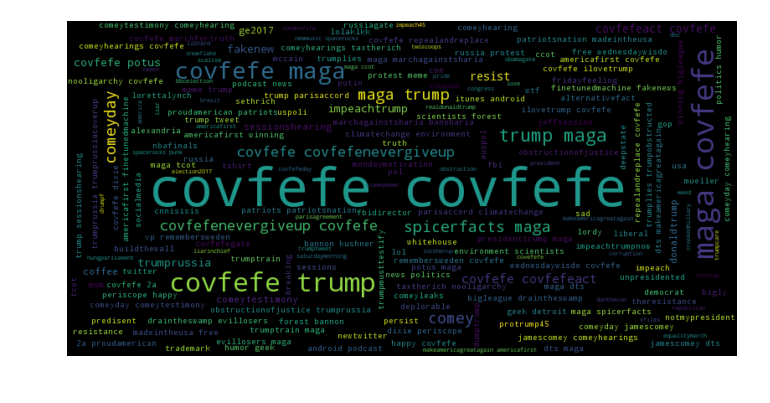

In [25]:
wordcloud = WordCloud(width=800, height=400).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [26]:
# I got better results with the word cloud generator at https://www.jasondavies.com/wordcloud/

In [27]:
no_retweets.head()

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name,hashtags_clean,hashtag_string
0,0,Fri Jun 16 13:13:32 +0000 2017,1336,"[{""text"": ""trump""}, {""text"": ""maga""}, {""text"":...",NaN,2017-06-17 22:45:08.039302,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",899,AMERICA AGREES! Gohmert: There Is No Collusion...,875702885572595712,"[{""expanded_url"": ""http://waynedupree.com/gohm...",192275.0,9517.0,🎙Wayne Dupree,282695161.0,en,USAF Desert Storm/Shield Vet,WayneDupreeShow,"[trump, maga, covfefe]",trump maga covfefe
1,1,Fri Jun 16 16:53:35 +0000 2017,389,"[{""text"": ""covfefe""}, {""text"": ""trump""}]",NaN,2017-06-17 22:45:08.039313,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",271,JUST FIRE MUELLER! Deputy AG Just Dropped Warn...,875758262959960068,"[{""expanded_url"": ""http://waynedupree.com/depu...",192275.0,9517.0,🎙Wayne Dupree,282695161.0,en,USAF Desert Storm/Shield Vet,WayneDupreeShow,"[covfefe, trump]",covfefe trump
2,2,Fri Jun 16 16:25:06 +0000 2017,497,"[{""text"": ""AmericaFirst""}, {""text"": ""covfefe""}...",NaN,2017-06-17 22:45:08.039318,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",281,#AmericaFirst - Obama's Anchor Baby Program (D...,875751095414521858,"[{""expanded_url"": ""http://waynedupree.com/trum...",192275.0,9517.0,🎙Wayne Dupree,282695161.0,en,USAF Desert Storm/Shield Vet,WayneDupreeShow,"[americafirst, covfefe, trump]",americafirst covfefe trump
5,5,Fri Jun 16 23:59:12 +0000 2017,1,"[{""text"": ""COVFEFE""}, {""text"": ""ISLAND""}]",NaN,2017-06-17 22:45:08.039330,"<a href=""http://instagram.com"" rel=""nofollow"">...",0,🎥 #COVFEFE #ISLAND DAY ONE! @ Corral Beach ht...,875865374897586176,"[{""expanded_url"": ""https://www.instagram.com/p...",70948.0,1793.0,DAVE,33977973.0,en,"los angeles, ca",Youngbeardo,"[covfefe, island]",covfefe island
7,7,Fri Jun 16 23:59:09 +0000 2017,0,"[{""text"": ""areyoukidding""}, {""text"": ""smh""}, {...",NaN,2017-06-17 22:45:08.039336,"<a href=""http://twitter.com/download/iphone"" r...",0,Lucky us to have such a distinguished leader. ...,875865361865859073,"[{""expanded_url"": ""https://twitter.com/realdon...",319.0,211.0,Carrie Blankenship,38244909.0,en,"Lake Stevens, WA",kidsinthecity,"[areyoukidding, smh, covfefe]",areyoukidding smh covfefe


In [28]:
# Getting vector counts on the text, first without limiting the number of features
cvec1 = CountVectorizer(stop_words='english', max_features=None)
cvec1.fit(no_retweets['hashtag_string'])

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [29]:
cvec1_df = pd.DataFrame(cvec1.transform(no_retweets['hashtag_string']).todense(), columns=cvec1.get_feature_names())

In [30]:
cvec1_df.shape

(17312, 5155)

In [31]:
cvec1_df.head()

,10000aday,10at10,1893pepsicola,1a,1notrump,2017election,2017propel,2017stanleycup,2018midtermelections,25for45,25thamendment,263chat,2a,2ksubs,2morrow,2ndamendment,2scoops,2scoopsofwinning,2xl,30for30,30kemail,3dchess,3mob,3stooges,3xl,45isaliar,45liarinchief,4chan,4dchess,4thdivorce,501pharmacy,5at630,5stepsahead,5watt,65million,65millionandcounting,80sflicks,96millionunemployed,9thcircuit,9thcircuitcourt,aas230,aave,abc,abcdefghijklmnopqrstuvwxyz,abeerbwaterloo,abitlatetotheparty,abouttime,abr,abs_2017,absolutely,abuseofpower,abusivemsm,abvsam,aca,accio,accountability,acleverkot,aclu,act,acting,action,activeshooter,activism,actlikeyouknow,actonclimate,actor,acupabove,adamwest,adderall,addicted,addiction,addme,adehh,admerica17,admin,admirable,adoptdontshop,adoptme,advantage,adventureswithtrump,affluezna,afghanistan,aflbluesgiants,aflpowerlions,africa,aftermytenthcupofcoffee,agentorange,agile,aglynch,agsessions,ahca,ahhhh,aidanfreeman,aintnobodyprayingforme,airforcephil,airtel,aka,akhaf822,al,alandershowitz,alaska,albaghdadi,albertsworld,alby,alcohol,alexandra,alexandria,alexandriashooter,alexandriashooting,alexandriava,alexendria,alexjones,aliencovenant,alleyezonme,allhailourubertrollking,allofus,allrepublicanstoday,allthepresidentsmen,allthewords,allutreasonistleftists,ally,allyrussia,alphabet,alpolitics,altashoras,alternatefacts,alternatefactsarelies,alternatefeatures,alternaterealities,alternatetruth,alternative,alternativeblacks,alternativeelection,alternativeelectionnight,alternativefacst,alternativefact,alternativefacts,alternativefairytales,alternativelanguage,alternativesobrietytests,alternativetech,alternitavewins,altfacts,altgov,altnews,altright,alwaysfunny,amandabynes,amazon,amazonstorebuilder,amberrose,amberrosechallenge,amberroseslutwalk,amd,amediting,amerexit,america,america1st,americafirst,american,americanacronymaward,americandream,americanhistory,americanhorrorstory,americanidiots,americantragedy,americaspeaksout,amidoingthisright,amiright,amjemeji,amjoy,amsterdamcs,amtrak,amwriting,amwritingfantasy,amyrose77253769,anabraga,anagram,analytics,anamericanhorrorstory,ancient,ancientaliens,ancienthistory,andersoncooper,andgelamerkel,andhot,android,andthewinneris,angelamerkel,angermanagement,angusking,anifa,animals,animatronic,annoyedaf,annoyinghashtags,anonymous,anotherworld,anthem,anthemgame,anti,antichristtrump,antifa,antifacism,antifaisterrorgroup,antifasciste,antitrump,antitrumpmvmt,aol,api,apocalypse,apostrophe,app2017,applenews,apprentice,apprentices,approvalrating,aprilfool,archaeologists,archive,archives,areyoukidding,arf2017am,arizona,arlingtonma,armageddon,arrestcomey,arresttrump,art,artist,artistproof,artnude,arvokriisi,arvot,aryastark,asapalaban,ask,askingforafriend,asksrk,askurdoctor,asmbs,asmbsweekend,asphalt,ass,assassinatetrump,asshat,assyrianchristians,atrocious,attentiongrabber,atticusindepand,attorneygeneral,auction,audiojungle,aum,aus,auspol,australia,australianblog,australianpm,autism,autocorrect,autocorrectsucks,automutt,aviation,avocado,avocadotoast,awanbrothers,awayslosing,awesome,baaadteambuilding,baby,babydriver,babyman,babynixon,bachconcerti,bachelorinparadise,backfire,backintothewoods,backontheroad,backpeddler,backronym,backtobackchamps,backtothefuture2,backtowork,bacon,badass,badcoffee,badcoffeeroasters,badduet,badfaketan,badhombre,badhombres,badjokes,badmoviesequels,badnews,baldcap,ballotpaperscandal,baloney,balrism,bamenda,bamum,bamwhat,bangingmorning,banislam,bankofamerica,bannon,bansharia,bansharialaw,barcelona,barroness,barronesscockfefe,barrontrump,baseball,baseofmyshaft,basketball,bassavah,batman,batmanbegins,batmanslap,bay,bbc,bbcelection,bbuk,bbwla,bcbs,bdd,bdsm,beach,beachlife,beans,beardedmenarebetter,bearynice,beatingadeadhorseintotheground,beatles,beats1,beattheheatin4words,beautiful,beavisandbutthead,bebetter,becausecovfefe,becauseitsthecup,bedge,beer,beerandsweat,beergeek,beerpants,befit,behappy,believeland,believeme,belmontstakes,benandjerrys,benedictcomey,benghazi,ber

In [32]:
cvec1_top = cvec1_df.transpose().sort_values(0, ascending=False).transpose()

cvec1_top.head()

,maga,covfefe,trump,prayforyoutube,prayforotto,prayersforpotus,prayersforamerica,pray4djt,pralines,praisethelord,praisekek,10000aday,pra,pr,pplsummit,pouramericaadrinkagain,potustweets,potustrump,potuscountdown,potus45,potus3,prayforsteve,precedence,pre,predisentcovfefegate,preibus,pregameworkout,preexistingconditions,preetbharara,preds,predisenttrump,predisential,predisent,potus16,prediscent,predictablejoke,predators,precious,precident,precedential,precedental,potus26,potus1,presentation,pokies,politicalmeme,politicalcorrectness,politicalart,political,policelivesmatter,poland,pol,pokemonvgc,politicalscandal,pokemongo,pokemon,pokeem,pointless,poetryeveryday,poetry,poems,politicalretaliation,politicalsciencemajor,potus,popcorntime,pot,posttruthamerica,positive,pos,portrait,portland,popularvote,pooh,politico,ponyor,poncescheme,polls,politicssuck,politicsofenvy,politics,politicore,preppertalk,preserve,poe,progressive,propaganda,pronunciation,prolife,prole,projectpabst,projecting,progressives,profitoverpeople,protestagainstnothing,profitcy,produce,procecute,probsolved,probablyalreadysaid,prizes,privilege,protest,protests,prisonbound,pseudologiafantastica,pubg,ptown,pt,psychopotus,psychologists,pspuoluekokous,psn,psepki,protestwhileyoupoop,ps4nplvic,ps4e3,ps4,prowrestling,prouddeplorable,proudamerican,protrump45,privateequity,prison2018,preservethecovfefe,presidentialelection,presidentielles2017,presidentialtwitterlibrary,presidentialtweets,presidentialrecordsact,presidentialrecords,presidentialrecord,presidentialexcuses,presidentialarchives,presidents,presidential,presidentfun,presidentdonaldtrump,presidentclownshoes,presidentbob,presidentbannon,president,presidentleaker,presidenttrump,princebarron,prevalent,prideweekend,prideparade,pridemonth,pridemarch,prideday,pride2017,pride,pretence,presidenttweets,presstitutes,presssecretary,presspass,pressefreiheit,presscovfefe,pressbriefing,press,poem,podcastday,podernfamily,publiclands,patreon,pathological,patents,patentnews,patentlaw,patent,pasta,passthepopcorn,passthecoffee,partyovercountry,partyfavors,party,partisanpolitics,parody,parkingchange,parisclimatedeal,parisairforum,patriaenergy,patrickesque,patriot,pbr,peach,peaceandmedicate,peace,peaberry,pdx,pdf17,pcaga,paypal,patriotism,payattention,pawsofliberty,paulryan,patronus,patriotsummer,patriotsnation,patriots,parisagreement,parisaccord,paris,ourrevolutioncontinues,overwatch,overthrowthequeen,overload,overdrive,overandout,outoftouch,outnumbered,ourrevolution,ownup,ourpresidentmusttestify,ourhouse,ottowarmbier,otto,ottnews,otherthingssessionscantrecall,orwellian,overwatchcoffee,ownyourcareer,pari,pakistan,parenting,paranoia,papparaqua,panworthy,pancakesquirrel,pakvsl,pakveng,pairs,ownyourmistakes,paintings,painter,painkillers,pachulia,p45,p2,oy,peaktwitter,pedagoofriday,pedogate,photooftheday,pigtown,piglet,piggybank,pieve,picard,phuket,photoshopfun,photograph,pinlig,phonypresident,phoenix,philosophy,phillipines,phenomenon,phd,pfm,pink,piratesofthecaribbean,pettypresident,pleasecallnow,podcast,pm,pllendgame,plinko,pledgeofallegiance,plebiscito,pleaseexcusemefor,playstatione3,pitbull,plannedparenthood,planetnomorals,planetgreed,placel,pjnet,pizza,pittsburghpride,pffft,petty,pedophile,pence2024,penticton,pens,pennsylvania,penguins,penclick,pencelawyersup,penceknew,pelosigalore,peoplespresident,peetapes,peetape,peepeetape,peepeepresident,peepee,peeotus,peek_r,people,pepe,pets,persiangulf,petrolhead,petition,pet,pervert,perth,persistence,persist,persian,pepsisummer,perpwalks,perjury,periscope,periodictable,period,perified,perfect,publichousing,publicrecords,orioles,russianpresidentoftheunitedstates,ruleorruin,ruleoflaw,ruiningusa,rueters,ruby,rubio,rubes4trump,rsrsrs,rsbnetwork,rsavfra,rpdr,royalty,roy,roufs,roseville,rosensteinstatement,rosenstein,rules,runkeeper,runway,russiamyrussia,russianinvestigation,russianhookerspeepee,russianhookers,russianhacking,russianfairytale,russiancollusion,russian,russiainvestigation,rupaul,russiahoax,r

In [33]:
# getting vector counts on the text
#limiting max_features to about 10% of the total features to remove rare hashtags, keep all with at least 4 occurrences
cvec = CountVectorizer(stop_words='english', max_features=520) 
cvec.fit(no_retweets['hashtag_string'])

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=520, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [34]:
cvec_df = pd.DataFrame(cvec.transform(no_retweets['hashtag_string']).todense(), columns=cvec.get_feature_names())

In [35]:
cvec_df.shape

(17312, 520)

In [36]:
sums = [sum(cvec_df[x]) for x in cvec_df.columns]

In [37]:
sums_table = pd.DataFrame(sums, cvec_df.columns, columns=['occurrences'])

In [38]:
sums_table.sort_values('occurrences', ascending=False)

,occurrences
covfefe,17408
maga,1781
trump,1316
comeyday,308
comey,276
spicerfacts,243
covfefeact,211
covfefenevergiveup,208
resist,166
trumprussia,156


In [39]:
cvec_df.columns

Index([u'10at10', u'2017election', u'2a', u'absolutely', u'abuseofpower',
       u'aca', u'accountability', u'act', u'activism', u'actonclimate',
       ...
       u'worstpotusever', u'worstpresidentever', u'writing',
       u'writtenonmytombstone', u'wtf', u'xfiles', u'youthwakeupcall',
       u'youtube', u'yuge', u'zazzle'],
      dtype='object', length=520)

In [40]:
X = cvec.transform(no_retweets['hashtag_string'])

In [41]:
X

<17312x520 sparse matrix of type '<type 'numpy.int64'>'
	with 29705 stored elements in Compressed Sparse Row format>

In [42]:
docs = pd.DataFrame(X.todense(), columns=cvec.get_feature_names())
docs.sum()

10at10                               8
2017election                         4
2a                                  68
absolutely                           8
abuseofpower                         6
aca                                  7
accountability                       4
act                                 13
activism                             4
actonclimate                         4
ahca                                 9
alexandria                          20
alexandriava                         4
alternativefacts                    69
amazon                               8
america                             11
americafirst                       115
amwriting                            5
andersoncooper                       7
android                             17
antifa                               9
art                                  4
auspol                              17
banislam                             4
bannon                              33
bansharia                

In [43]:
# Setting up the vocab, dictionary, and corpus to use in gensim's LdaModel
vocab = {v: k for k, v in cvec.vocabulary_.iteritems()}

In [44]:
len(vocab)

520

In [45]:
frequency = defaultdict(int)

for text in no_retweets['hashtag_string']:
    for token in text.split():
        frequency[token] += 1
        
frequency

defaultdict(int,
            {'missjetsetmagazine': 1,
             'shitforbrainspresident': 2,
             'whoops': 1,
             'drumpf': 13,
             'obstruction': 10,
             'protest': 34,
             'jihad': 1,
             'juliuscaesar': 5,
             'blm': 1,
             'canes': 1,
             'spellcheck': 4,
             'maxinewatershastogo': 2,
             'digitaltrends': 1,
             'aum': 1,
             'cumberlandfarms': 1,
             'aus': 1,
             'djusa': 1,
             'sorry': 1,
             'kickthetoriesout': 1,
             'saturdaynight': 2,
             'cavaliers': 1,
             'saskatchewan': 1,
             'incestigating': 1,
             'skynews': 1,
             'abuseofpower': 6,
             'trumprussiacollusion': 2,
             'harambe': 3,
             'centralpark5': 1,
             'wtfiswrongwiththisworld': 1,
             'finetunedmachine': 15,
             'snowflakes': 2,
             'wednesd

In [46]:
texts = [[token for token in text.split() if frequency[token] > 3]
          for text in no_retweets['hashtag_string']]

texts

[['trump', 'maga', 'covfefe'],
 ['covfefe', 'trump'],
 ['americafirst', 'covfefe', 'trump'],
 ['covfefe'],
 ['smh', 'covfefe'],
 ['covfefe'],
 ['covfefe', 'potus', 'maga'],
 ['cnnisisis', 'covfefe', 'maga'],
 ['alternativefacts', 'covfefe', 'covfefeyourself', 'fakenews'],
 ['covfefe'],
 ['cnn', 'covfefe'],
 ['covfefe'],
 ['covfefe', 'tcot'],
 ['covfefe'],
 ['covfefe'],
 ['maga', 'trump', 'covfefe'],
 ['covfefe'],
 ['covfefe'],
 ['covfefe'],
 ['covfefe'],
 ['covfefe'],
 ['covfefe'],
 ['covfefe', 'trump', 'maga'],
 ['covfefe', 'tcot'],
 ['covfefe'],
 ['snl', 'spicerfacts', 'maga', 'covfefe'],
 ['covfefe'],
 ['covfefe', 'accountability', 'transparency'],
 ['maga', 'covfefe'],
 ['covfefe'],
 ['covfefe'],
 ['covfefe', 'maga'],
 ['covfefe'],
 ['covfefe'],
 ['covfefe'],
 ['covfefe'],
 ['covfefe'],
 ['covfefe', 'maga'],
 ['covfefe'],
 ['maga', 'trump', 'covfefe'],
 ['covfefe', 'trump', 'maga'],
 ['spicerfacts', 'maga', 'covfefe'],
 ['covfefe'],
 ['msm', 'fakenews', 'covfefe'],
 ['covfefe'],
 [

In [47]:
len(texts)

17312

In [48]:
# Create gensim dictionary object
dictionary = corpora.Dictionary(texts)
#dictionary

## Another option for setting up the dictionary:
# no_below sets the minimum number of occurrences and no_above sets the maximum proportion of rows that contain a certain value (0-1)

#dictionary = corpora.Dictionary(texts)
#dictionary.filter_extremes(no_below=4, no_above=1, keep_n=None)
#dictionary.compactify()

In [49]:
len(dictionary)

524

In [50]:
# Create corpus matrix
corpus = [dictionary.doc2bow(text) for text in texts]
corpus

[[(0, 1), (1, 1), (2, 1)],
 [(1, 1), (2, 1)],
 [(1, 1), (2, 1), (3, 1)],
 [(2, 1)],
 [(2, 1), (4, 1)],
 [(2, 1)],
 [(0, 1), (2, 1), (5, 1)],
 [(0, 1), (2, 1), (6, 1)],
 [(2, 1), (7, 1), (8, 1), (9, 1)],
 [(2, 1)],
 [(2, 1), (10, 1)],
 [(2, 1)],
 [(2, 1), (11, 1)],
 [(2, 1)],
 [(2, 1)],
 [(0, 1), (1, 1), (2, 1)],
 [(2, 1)],
 [(2, 1)],
 [(2, 1)],
 [(2, 1)],
 [(2, 1)],
 [(2, 1)],
 [(0, 1), (1, 1), (2, 1)],
 [(2, 1), (11, 1)],
 [(2, 1)],
 [(0, 1), (2, 1), (12, 1), (13, 1)],
 [(2, 1)],
 [(2, 1), (14, 1), (15, 1)],
 [(0, 1), (2, 1)],
 [(2, 1)],
 [(2, 1)],
 [(0, 1), (2, 1)],
 [(2, 1)],
 [(2, 1)],
 [(2, 1)],
 [(2, 1)],
 [(2, 1)],
 [(0, 1), (2, 1)],
 [(2, 1)],
 [(0, 1), (1, 1), (2, 1)],
 [(0, 1), (1, 1), (2, 1)],
 [(0, 1), (2, 1), (13, 1)],
 [(2, 1)],
 [(2, 1), (9, 1), (16, 1)],
 [(2, 1)],
 [(2, 1)],
 [(0, 1), (2, 1), (17, 1)],
 [(2, 1)],
 [(1, 1), (2, 1), (18, 1), (19, 1)],
 [(2, 1)],
 [(2, 1)],
 [(2, 1)],
 [(2, 1)],
 [(2, 1)],
 [(2, 1)],
 [(0, 1), (1, 1), (2, 1), (20, 1)],
 [(2, 1)],
 [(2, 1)

In [51]:
len(corpus)

17312

In [52]:
lda3 = models.LdaModel(
    matutils.Sparse2Corpus(X, documents_columns=False),
    num_topics  =  3,
    passes      =  20,
    id2word     =  dictionary
)

lda2 = models.LdaModel(
    matutils.Sparse2Corpus(cvec.transform(df['hashtag_string']), documents_columns=False),
    num_topics  =  2,
    passes      =  20,
    id2word     =  dictionary
)

In [53]:
lda3.print_topics(num_topics=3, num_words=20)

[(0,
  u'0.907*"newmusic" + 0.012*"theresistance" + 0.010*"nyc" + 0.007*"warriors" + 0.006*"deplorables" + 0.004*"sessionstestimony" + 0.002*"persiangulf" + 0.002*"marchagainstsharia" + 0.002*"nba" + 0.002*"gratitude" + 0.002*"2a" + 0.001*"nairobi" + 0.001*"trumpbirthday" + 0.001*"sethrichcoverup" + 0.001*"protrump45" + 0.001*"madeintheusa" + 0.001*"cake" + 0.001*"mentalhealth" + 0.001*"buildthewall" + 0.001*"treason"'),
 (1,
  u'0.224*"newmusic" + 0.074*"fridayfeeling" + 0.045*"trumprussia" + 0.025*"amwriting" + 0.023*"fallontonight" + 0.023*"lgbtq" + 0.021*"punk" + 0.018*"nowplaying" + 0.017*"kushner" + 0.017*"news" + 0.016*"msm" + 0.015*"russian" + 0.015*"president" + 0.012*"kathygriffin" + 0.012*"unpresidented" + 0.011*"spicerfacts" + 0.009*"equality" + 0.009*"morningjoe" + 0.009*"aca" + 0.009*"hashtags"'),
 (2,
  u'0.288*"newmusic" + 0.155*"evillosers" + 0.111*"quigley" + 0.078*"mueller" + 0.024*"twitter" + 0.021*"ip" + 0.017*"firemuellernow" + 0.015*"government" + 0.008*"vote" + 

### Results:
I tried LDA modeling with 3, 4, 5, 6, 7, 8, and up-to-50 topics. Based on the interpretability of the topics generated, I found that three topics fit the data the best. So, I performed the most analysis on the first model below, with 3 topics, but I include the other models below for those who want to judge for themselves how many topics appear in the data.

### Visualizing LDA topic clusters

from https://pyldavis.readthedocs.io/en/latest/modules/API.html#pyLDAvis.display


I used pyLDAvis to generate the topic visualization below.

In [54]:
lda_vis3 = pyLDAvis.gensim.prepare(lda3, corpus, dictionary)

In [55]:
pyLDAvis.display(lda_vis3)

In [56]:
mystery = df[df['hashtag_string'].map(lambda x: 'newmusic' in x)]

mystery.shape

(33, 20)

In [57]:
mystery

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name,hashtags_clean,hashtag_string
866,866,Fri Jun 16 19:05:33 +0000 2017,0,"[{""text"": ""spacerocks""}, {""text"": ""punk""}, {""t...",NaN,2017-06-17 22:45:14.112723,"<a href=""http://melodicdirt.com"" rel=""nofollow...",1,RT @JakeFromSpace: JakeFromSpace-Weed https://...,875791474499223554,"[{""expanded_url"": ""https://youtu.be/-RG18hXpqp...",10177.0,6238.0,melodic DIRT,1.398457e+09,en,NaN,melodicDIRT,"[spacerocks, punk, grunge, newmusic, covfefe, ...",spacerocks punk grunge newmusic covfefe weed
873,873,Fri Jun 16 19:02:51 +0000 2017,0,"[{""text"": ""newmusic""}, {""text"": ""spacerocks""},...",NaN,2017-06-17 22:45:14.112755,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,JakeFromSpace-My Cock Is Earths Antenna To Out...,875790796129226752,"[{""expanded_url"": ""https://youtu.be/Amrja7QmJQ...",1144.0,4997.0,JakeFromSpace,7.552310e+07,en,Space,JakeFromSpace,"[newmusic, spacerocks, punk, covfefe, weed]",newmusic spacerocks punk covfefe weed
883,883,Fri Jun 16 19:00:03 +0000 2017,1,"[{""text"": ""spacerocks""}, {""text"": ""punk""}, {""t...",NaN,2017-06-17 22:45:14.112806,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",1,JakeFromSpace-Weed https://t.co/tvw3rjpC4A via...,875790089292533766,"[{""expanded_url"": ""https://youtu.be/-RG18hXpqp...",1144.0,4997.0,JakeFromSpace,7.552310e+07,en,Space,JakeFromSpace,"[spacerocks, punk, grunge, newmusic, covfefe, ...",spacerocks punk grunge newmusic covfefe weed
886,886,Fri Jun 16 18:58:20 +0000 2017,0,"[{""text"": ""newmusic""}, {""text"": ""spacerocks""},...",NaN,2017-06-17 22:45:14.112820,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,JakeFromSpace-energetic https://t.co/HZq3UeBrR...,875789659271553025,"[{""expanded_url"": ""https://youtu.be/52Bd5SMPFJ...",1144.0,4997.0,JakeFromSpace,7.552310e+07,en,Space,JakeFromSpace,"[newmusic, spacerocks, punk, covfefe, weed]",newmusic spacerocks punk covfefe weed
3900,3898,Fri Jun 16 02:13:29 +0000 2017,1,"[{""text"": ""newmusic""}, {""text"": ""spacerocks""},...",NaN,2017-06-17 22:45:37.325257,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,JakeFromSpace-Floaty https://t.co/oQromW29mo v...,875536781038538752,"[{""expanded_url"": ""https://youtu.be/BYia_IxATI...",1144.0,4997.0,JakeFromSpace,7.552310e+07,en,Space,JakeFromSpace,"[newmusic, spacerocks, punk, foofighters, grun...",newmusic spacerocks punk foofighters grunge co...
5214,5212,Thu Jun 15 21:20:49 +0000 2017,0,"[{""text"": ""newmusic""}, {""text"": ""spacerocks""},...",NaN,2017-06-17 22:45:45.542138,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,JakeFromSpace-Back To Back https://t.co/FqqJxH...,875463127533408256,"[{""expanded_url"": ""https://youtu.be/V9sVLhHu4q...",1144.0,4997.0,JakeFromSpace,7.552310e+07,en,Space,JakeFromSpace,"[newmusic, spacerocks, punk, covfefe, weed]",newmusic spacerocks punk covfefe weed
5218,5216,Thu Jun 15 21:19:31 +0000 2017,0,"[{""text"": ""spacerocks""}, {""text"": ""newmusic""},...",NaN,2017-06-17 22:45:45.542155,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,JakeFromSpace-Malibu https://t.co/cMshGIEwWc v...,875462801992466432,"[{""expanded_url"": ""https://youtu.be/fIL5RLqEqC...",1144.0,4997.0,JakeFromSpace,7.552310e+07,en,Space,JakeFromSpace,"[spacerocks, newmusic, punk, covfefe, weed, hole]",spacerocks newmusic punk covfefe weed hole
12209,12206,Wed Jun 14 20:41:13 +0000 2017,0,"[{""text"": ""newmusic""}, {""text"": ""RollingStones...",NaN,2017-06-17 22:46:42.167727,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,JakeFromSpace-Love is Strong https://t.co/jud7...,875090775205457923,"[{""expanded_url"": ""https://youtu.be/cG2qB-zkd2...",1144.0,4997.0,JakeFromSpace,7.552310e+07,en,Space,JakeFromSpace,"[newmusic, rollingstones, spacerocks, covfefe]",newmusic rollingstones spacerocks cov

In [58]:
mystery2 = df[df['hashtag_string'].map(lambda x: 'evillosers' in x)]

mystery2.shape

(56, 20)

In [59]:
mystery2

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name,hashtags_clean,hashtag_string
7544,7541,Thu Jun 15 14:58:33 +0000 2017,0,"[{""text"": ""Covfefe""}, {""text"": ""AmericaFirst""}...",NaN,2017-06-17 22:46:01.166822,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,They can't stop.\n#Covfefe \n#AmericaFirst \n#...,875366925525590020,"[{""expanded_url"": ""https://twitter.com/realDon...",1496.0,1979.0,Ray Koagel,4.938475e+07,en,Huntington Beach CA,RayKoagel,"[covfefe, americafirst, winning, bigleague, dr...",covfefe americafirst winning bigleague drainth...
7548,7545,Thu Jun 15 14:57:54 +0000 2017,0,"[{""text"": ""BigLeague""}, {""text"": ""Covfefe""}, {...",NaN,2017-06-17 22:46:01.166841,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,Looks like they want us #BigLeague \n#Covfefe ...,875366763055030273,"[{""expanded_url"": ""https://twitter.com/i/web/s...",1496.0,1979.0,Ray Koagel,4.938475e+07,en,Huntington Beach CA,RayKoagel,"[bigleague, covfefe, americafirst, winning, bi...",bigleague covfefe americafirst winning bigleag...
14128,14125,Wed Jun 14 14:58:45 +0000 2017,1,"[{""text"": ""Covfefe""}, {""text"": ""AmericaFirst""}...",NaN,2017-06-17 22:46:55.495411,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,Happy Birthday.\n#Covfefe \n#AmericaFirst \n#W...,875004589002510336,"[{""expanded_url"": ""https://twitter.com/MycaLyn...",1496.0,1979.0,Ray Koagel,4.938475e+07,en,Huntington Beach CA,RayKoagel,"[covfefe, americafirst, winning, bigleague, dr...",covfefe americafirst winning bigleague drainth...
17021,17018,Wed Jun 14 02:38:29 +0000 2017,0,"[{""text"": ""Sessions""}, {""text"": ""Covfefe""}, {""...",NaN,2017-06-17 23:00:35.439877,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,#Sessions won that round.\n#Covfefe \n#America...,874818296998121472,"[{""expanded_url"": ""https://twitter.com/XNSNews...",1496.0,1979.0,Ray Koagel,4.938475e+07,en,Huntington Beach CA,RayKoagel,"[sessions, covfefe, americafirst, winning, big...",sessions covfefe americafirst winning bigleagu...
17033,17030,Wed Jun 14 02:35:12 +0000 2017,0,"[{""text"": ""Covfefe""}, {""text"": ""AmericaFirst""}...",NaN,2017-06-17 23:00:35.915790,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,The Dems will blame the Martians next.\n#Covfe...,874817468904034304,"[{""expanded_url"": ""https://twitter.com/i/web/s...",1496.0,1979.0,Ray Koagel,4.938475e+07,en,Huntington Beach CA,RayKoagel,"[covfefe, americafirst, winning, bigleague, dr...",covfefe americafirst winning bigleague drainth...
17041,17038,Wed Jun 14 02:33:33 +0000 2017,0,"[{""text"": ""FakeNews""}, {""text"": ""Covfefe""}, {""...",NaN,2017-06-17 23:00:35.915828,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,Money talks #FakeNews sells.\n#Covfefe \n#Amer...,874817053231796224,"[{""expanded_url"": ""https://twitter.com/realDon...",1496.0,1979.0,Ray Koagel,4.938475e+07,en,Huntington Beach CA,RayKoagel,"[fakenews, covfefe, americafirst, winning, big...",fakenews covfefe americafirst winning bigleagu...
17042,17039,Wed Jun 14 02:33:03 +0000 2017,0,"[{""text"": ""Covfefe""}, {""text"": ""AmericaFirst""}...",NaN,2017-06-17 23:00:35.915833,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,It's not a ban?\n#Covfefe \n#AmericaFirst \n#W...,874816928170229760,"[{""expanded_url"": ""https://twitter.com/realDon...",1496.0,1979.0,Ray Koagel,4.938475e+07,en,Huntington Beach CA,RayKoagel,"[covfefe, americafirst, winning, bigleague, dr...",covfefe americafirst winning bigleague drainth...
17045,17042,Wed Jun 14 02:32:31 +0000 2017,1,"[{""text"": ""Covfefe""}, {""text"": ""AmericaFirst""}...",NaN,2017-06-17 23:00:35.915847,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,@Corrynmb @realDonaldTrump Wow @Corrynmb .\n#C...,874816794225070081,[],1496.0,1979.0,Ray Koagel,4.938475e+07,en,Huntington Beach 

In [60]:
mystery3 = df[df['hashtag_string'].map(lambda x: 'fridayfeeling' in x)]

mystery3.shape

(260, 20)

In [61]:
mystery3

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name,hashtags_clean,hashtag_string
694,694,Fri Jun 16 20:07:50 +0000 2017,0,"[{""text"": ""FridayFeeling""}, {""text"": ""NewTwitt...",NaN,2017-06-17 22:45:13.238822,"<a href=""http://twitter.com/download/android"" ...",0,@bessbell @POTUS Or put a Cuban cigar in the b...,875807148353236993,[],281.0,1198.0,soodlee™,5.250681e+07,en,"NJ,NY,India",isoodlee,"[fridayfeeling, newtwitter, amazon, wholefoods...",fridayfeeling newtwitter amazon wholefoods cov...
854,854,Fri Jun 16 19:08:18 +0000 2017,0,"[{""text"": ""covfefe""}, {""text"": ""fridayfeeling""}]",NaN,2017-06-17 22:45:14.112660,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,"When you get fresh #covfefe, it's the best #fr...",875792164986531840,[],12.0,13.0,Islamic Pacifist,8.097015e+17,en,Kingdom of Saudi Arabia,CaliphateNow,"[covfefe, fridayfeeling]",covfefe fridayfeeling
1003,1003,Fri Jun 16 18:18:46 +0000 2017,0,"[{""text"": ""Trumpcare""}, {""text"": ""FridayFeelin...",NaN,2017-06-17 22:45:15.269371,"<a href=""http://twitter.com/download/android"" ...",1,@jfreewright @GOP now specializes in spineless...,875779700584574978,[],281.0,1198.0,soodlee™,5.250681e+07,en,"NJ,NY,India",isoodlee,"[trumpcare, fridayfeeling, impeachtrump, muell...",trumpcare fridayfeeling impeachtrump mueller c...
1232,1232,Fri Jun 16 17:16:26 +0000 2017,6,"[{""text"": ""FridayFeeling""}, {""text"": ""Covfefe""...",NaN,2017-06-17 22:45:16.793252,"<a href=""http://twitter.com/download/android"" ...",0,@peddoc63 And she claims she is a doctor!\nWow...,875764014822957056,[],281.0,1198.0,soodlee™,5.250681e+07,en,"NJ,NY,India",isoodlee,"[fridayfeeling, covfefe, impeachtrump, grenfel...",fridayfeeling covfefe impeachtrump grenfelltow...
1742,1742,Fri Jun 16 15:19:22 +0000 2017,0,"[{""text"": ""FridayFeeling""}, {""text"": ""ImpeachT...",NaN,2017-06-17 22:45:20.066334,"<a href=""http://twitter.com/download/android"" ...",0,@realDonaldTrump Which hunt are u talking abou...,875734552190357504,[],281.0,1198.0,soodlee™,5.250681e+07,en,"NJ,NY,India",isoodlee,"[fridayfeeling, impeachtrump, amazon, covfefe,...",fridayfeeling impeachtrump amazon covfefe maga
1783,1783,Fri Jun 16 15:07:20 +0000 2017,0,"[{""text"": ""ExposeTheLeft""}, {""text"": ""Covfefe""...",NaN,2017-06-17 22:45:20.486400,"<a href=""http://twitter.com/download/iphone"" r...",0,@Twitter Why is it when I include @ P-O-T-U-S ...,875731526104883201,[],7827.0,5531.0,🇺🇸Liberty Bell🇺🇸,7.311943e+17,en,"New York, USA",michellerj1019,"[exposetheleft, covfefe, witchhunt, fridayfeel...",exposetheleft covfefe witchhunt fridayfeeling ...
2110,2110,Fri Jun 16 13:43:11 +0000 2017,1,"[{""text"": ""Covfefe""}, {""text"": ""FridayFeeling""...",NaN,2017-06-17 22:45:23.283138,"<a href=""http://twitter.com/download/android"" ...",0,@realDonaldTrump You got me so confused this m...,875710347579097088,"[{""expanded_url"": ""https://twitter.com/i/web/s...",454.0,308.0,Kikkay,4.796854e+08,en,New York City,NikkisBubble,"[covfefe, fridayfeeling, trumprussia]",covfefe fridayfeeling trumprussia
2251,2251,Fri Jun 16 13:04:22 +0000 2017,129,"[{""text"": ""FridayFeeling""}, {""text"": ""Resistan...",NaN,2017-06-17 22:45:24.631760,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",61,#FridayFeeling\nDemocrats aren't putting up #R...,875700580810989569,[],17533.0,10009.0,Rex Tilllerson,4.100817e+09,en,NOT Slightly Cowardly,RexTilllerson,"[fridayfeeling, resistance, covfefe]",fridayfeeling resistance covfefe
24662,24652,Tue Jun 13 02:07:11 +0000 2017,0,"[{""text"": ""BarronTrump""}, {""text"": ""FridayFeel...",NaN,2017-06-17 23:01:39.077971,"<a href=""http://twitter.com/#!/download/ipad"" ...",4,RT @jenny_mcgirr: These are truly the bottom f...,874448029654409218,[],5508.0,5458.0,Seekeroftruth0,5.985493e+08,en,maryland,SeekerofTruth0,"[barrontrump, fridayfeeling, 

In [62]:
# Assigns the topics to the documents in corpus
lda3_corpus = lda3[corpus]

In [63]:
# Assigning scores for each set of hashtags for each topic found by the model so that I can identify the tweets that score highest
# for each topic. These tweets will help with interpretability, to give typical examples of what the topics are pinpointing.
scores = list(chain(*[[score for topic_id,score in topic] \
                      for topic in [doc for doc in lda3_corpus]]))

In [64]:
threshold = 0.6 # setting the threshold to the level that identifies a manageable number of high scoring hashtag sets

In [65]:
cluster1 = [j for i,j in zip(lda3_corpus, no_retweets['hashtag_string']) if i[0][1] > threshold]
print cluster1

# Note: Due to expected variation in the LDA modeling process, the lists of highest scoring hashtag sets for each cluster
# differ from the first time I ran the model and the most recent time I ran the model. Thus, the list in this output
# does not match the hashtag sets I found in the following cells.

['trump trumplies trumppresidency shitsandwich nyc housing covfefe', 'deplorables trump conservatives covfefe', 'covfefellatio resist', 'thethreecovfefe trump', 'covfefe resist theresistance fucktrump', 'obamanation wolfinsheepscothing obamalegacy trump buildthewall nosharia notcompatible constitution covfefe', 'thethreecovfefe trump', 'trump theresistance politics covfefe comey', 'drumpf trump snowflakes triggered hipster dankmeme crybaby youngrepublicans covfefe', 'trump comey lies fbi covfefe', 'obstructionofjustice theresistance notmypresident covfefe riseup', 'covfefe comey ahca trumpcare', 'trump covfefe mexico fbi comey']


In [66]:
# Finding the tweets with the highest scoring hashtag sets
no_retweets[no_retweets['hashtag_string'] == 'testifefe testifefe testifefe covfefe']

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name,hashtags_clean,hashtag_string
101119,43730,Sat Jun 10 14:12:43 +0000 2017,0,"[{""text"": ""TESTIFEFE""}, {""text"": ""TESTIFEFE""},...",NaN,2017-06-17 23:17:10.332872,"<a href=""http://twitter.com/download/android"" ...",0,@SHSanders45 📶🚧🚦🚦🚦🚥💅💅👽🚦🚥100% #TESTI...,873543453233360896,[],23.0,107.0,#NASTYwomen 💯%,723372114.0,en,NaN,joy4lly2u,"[testifefe, testifefe, testifefe, covfefe]",testifefe testifefe testifefe covfefe


In [67]:
no_retweets[no_retweets['hashtag_string'] == 'covfefe protrump45 virginia virginiashooting']

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name,hashtags_clean,hashtag_string
10056,10053,Thu Jun 15 01:42:25 +0000 2017,1,"[{""text"": ""Covfefe""}, {""text"": ""ProTrump45""}, ...",NaN,2017-06-17 22:46:27.871197,"<a href=""http://twitter.com/download/android"" ...",0,@FCC @SecretService @NSAGov @FBI @jeffsessions...,875166573593591809,"[{""expanded_url"": ""https://twitter.com/i/web/s...",1259.0,2037.0,Mr. Average Joe,3.960052e+09,en,"Kentucky, USA",BrandonNeal212,"[covfefe, protrump45, virginia, virginiashooting]",covfefe protrump45 virginia virginiashooting


In [68]:
no_retweets[no_retweets['hashtag_string'] == 'covfefe mug zazzle coffee tea politics political progressive sandersinstitute']

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name,hashtags_clean,hashtag_string
36037,36022,Sun Jun 11 18:58:04 +0000 2017,4,"[{""text"": ""Covfefe""}, {""text"": ""Mug""}, {""text""...",NaN,2017-06-17 23:16:05.215500,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",2,"Yell Bernie, Yell #Covfefe #Mug https://t.co/4...",8.73978e+17,"[{""expanded_url"": ""https://www.zazzle.com/z/yi...",12.0,86.0,Its Trumplicated,8.739452e+17,en,"New York, USA",ItsTrumplicated,"[covfefe, mug, zazzle, coffee, tea, politics, ...",covfefe mug zazzle coffee tea politics politic...


In [69]:
no_retweets[no_retweets['hashtag_string'] == 'republicanvalues richgetricher whatmiddleclass profitoverpeople noprofitmaking healthcareaffortable covfefe']

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name,hashtags_clean,hashtag_string
106278,48889,Fri Jun 09 17:57:37 +0000 2017,0,"[{""text"": ""RepublicanValues""}, {""text"": ""RichG...",NaN,2017-06-17 23:31:04.078020,"<a href=""http://twitter.com/download/android"" ...",0,@TheTruth24US #RepublicanValues #RichGetRicher...,873237661653323777,[],311.0,1677.0,EnriG,20766030.0,en,"Mango, FL",enriquegg34,"[republicanvalues, richgetricher, whatmiddlecl...",republicanvalues richgetricher whatmiddleclass...
107959,50570,Fri Jun 09 13:38:05 +0000 2017,0,"[{""text"": ""RepublicanValues""}, {""text"": ""RichG...",NaN,2017-06-17 23:31:18.474241,"<a href=""http://twitter.com/download/android"" ...",0,@LeahR77 #RepublicanValues #RichGetRicher #Wha...,873172350111502336,[],311.0,1677.0,EnriG,20766030.0,en,"Mango, FL",enriquegg34,"[republicanvalues, richgetricher, whatmiddlecl...",republicanvalues richgetricher whatmiddleclass...
114122,56729,Thu Jun 08 20:08:47 +0000 2017,0,"[{""text"": ""RepublicanValues""}, {""text"": ""RichG...","[{""display_url"": ""pic.twitter.com/OxDLW2CwXy"",...",2017-06-17 23:32:09.954619,"<a href=""http://twitter.com/download/android"" ...",0,#RepublicanValues #RichGetRicher #WhatMiddleCl...,872908283924946945,[],311.0,1677.0,EnriG,20766030.0,en,"Mango, FL",enriquegg34,"[republicanvalues, richgetricher, whatmiddlecl...",republicanvalues richgetricher whatmiddleclass...


In [70]:
# Repeating the process for cluster2
cluster2 = [j for i,j in zip(lda3_corpus, no_retweets['hashtag_string']) if i[1][1] > 0.85]
print cluster2

['fakenews witchhunt maga covfefe', 'democrats liberals refute republicans covfefe ti', 'sessions clintonfoundation republicans maga covfefe', 'makeamericagreatagain standwithtrump covfefe maga', 'covfefe covfefe covfefe scrotus', 'alternativefacts alternaterealities sessionshearing huckabee sessionsday covfefe', 'congress unbelievable covfefe draintheswamp maga', 'covfefe covfefe covfefe maga', 'sessionshearing msnbc jeffsessions attorneygeneral maga covfefe', 'covfefe ccovfefe covfefe maga maga maga', 'sessionshearing jeffsessions covfefe maga', 'jeffsessions sessionshearing covfefe covfefe angusking sessions', 'sessions pathological liar sessionshearing jeffsessions covfefe', 'scurrilous covfefe sessionshearing sessionsday sessions', 'nosafespacesmovie ps4 psn ps4e3 xboxonex xbox e3 twitch twitche3 sessionshearing sessions maga covfefe', 'leadership fakenews alternativefacts covfefe realdonaldtrump', 'westandwithtrump covfefe persist sethrich', 'covfefe realdonaldtrump liarinchief r

In [71]:
no_retweets[no_retweets['hashtag_string'] == 'covfefe covfefe covfefe covfefe covfefe covfefe covfefe covfefe covfefe covfefe covfefe covfefe']

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name,hashtags_clean,hashtag_string
28039,28029,Mon Jun 12 20:20:45 +0000 2017,0,"[{""text"": ""COVFEFE""}, {""text"": ""COVFEFE""}, {""t...",NaN,2017-06-17 23:02:02.025051,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,#COVFEFE #COVFEFE #COVFEFE #COVFEFE #COVFEFE #...,874360847308472320,"[{""expanded_url"": ""https://twitter.com/i/web/s...",561.0,558.0,Kimcy,39835087.0,en,Los Angeles,carolinekimcy,"[covfefe, covfefe, covfefe, covfefe, covfefe, ...",covfefe covfefe covfefe covfefe covfefe covfef...


In [72]:
no_retweets[no_retweets['hashtag_string'] == 'covfefe covfefe covfefe covfefe covfefe covfefe']

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name,hashtags_clean,hashtag_string
107117,49728,Fri Jun 09 15:56:31 +0000 2017,0,"[{""text"": ""Covfefe""}, {""text"": ""Covfefe""}, {""t...",NaN,2017-06-17 23:31:10.488396,"<a href=""http://twitter.com/#!/download/ipad"" ...",0,"#Covfefe #Covfefe what should I do, I think I'...",873207186960375808,[],135.0,204.0,JustDavid,2.791622e+09,en,NaN,PapaSlavs,"[covfefe, covfefe, covfefe, covfefe, covfefe, ...",covfefe covfefe covfefe covfefe covfefe covfefe


In [73]:
no_retweets[no_retweets['hashtag_string'] == 'trump russia covfefe comey']

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name,hashtags_clean,hashtag_string
11611,11608,Wed Jun 14 22:12:50 +0000 2017,0,"[{""text"": ""trump""}, {""text"": ""russia""}, {""text...",NaN,2017-06-17 22:46:37.060869,"<a href=""http://twitter.com/download/iphone"" r...",0,Pre-sale on now! Start collecting and save 10%...,875113831219044353,"[{""expanded_url"": ""https://twitter.com/i/web/s...",2.0,13.0,Overtone Nutcrackers,8.649636e+17,en,NaN,overtoneNChouse,"[trump, russia, covfefe, comey]",trump russia covfefe comey


In [74]:
no_retweets[no_retweets['hashtag_string'] == 'covfefe trump deleting presidential tweets']

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name,hashtags_clean,hashtag_string
19282,19279,Tue Jun 13 19:42:24 +0000 2017,0,"[{""text"": ""Covfefe""}, {""text"": ""Trump""}, {""tex...","[{""display_url"": ""pic.twitter.com/S5Hag9Kr9k"",...",2017-06-17 23:00:51.170106,"<a href=""http://twitter.com/download/iphone"" r...",0,#Covfefe bill aims to stop #Trump #deleting #p...,874713582088445953,"[{""expanded_url"": ""http://news.sky.com/story/c...",1700.0,100.0,Dean Marius 🇬🇧,1.633770e+09,en,Great Britain,GT3Chap,"[covfefe, trump, deleting, presidential, tweets]",covfefe trump deleting presidential tweets


In [75]:
no_retweets[no_retweets['hashtag_string'] == 'covfefe trump auspol uspoli']

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name,hashtags_clean,hashtag_string
23310,23301,Tue Jun 13 08:14:30 +0000 2017,3,"[{""text"": ""Covfefe""}, {""text"": ""Trump""}, {""tex...",NaN,2017-06-17 23:01:27.832682,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",6,#Covfefe as law: anything #Trump tweets can be...,874540467689406464,"[{""expanded_url"": ""http://www.smh.com.au/world...",758.0,249.0,Rick Lane,927388044.0,en,NaN,ricklevy67,"[covfefe, trump, auspol, uspoli]",covfefe trump auspol uspoli


In [76]:
no_retweets[no_retweets['hashtag_string'] == 'trump covfefe comey lordyihopetherearetapes russia equalitymarch17']

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name,hashtags_clean,hashtag_string
36476,36461,Sun Jun 11 18:13:25 +0000 2017,0,"[{""text"": ""trump""}, {""text"": ""Covfefe""}, {""tex...",NaN,2017-06-17 23:16:08.640937,"<a href=""http://twitter.com/download/iphone"" r...",0,"Lordy, I need this shirt! https://t.co/pU5h546...",8.73966e+17,"[{""expanded_url"": ""https://teespring.com/cuz-e...",98.0,1921.0,StephStyles 💕💕,1.523493e+09,en,NaN,StephenieGleas1,"[trump, covfefe, comey, lordyihopetherearetape...",trump covfefe comey lordyihopetherearetapes ru...


In [77]:
# Repeating the process for cluster3
cluster3 = [j for i,j in zip(lda3_corpus, no_retweets['hashtag_string']) if i[2][1] > 0.75]
print cluster3

['lol lmao coffee covfefe love instagood me tbt cute follow', 'illiinoistech melaniethompson usrepresentative mikequigley covfefeact']


In [78]:
no_retweets[no_retweets['hashtag_string'] == 'tcot wakeupamerica rednationrising teaparty trumptrain maga pjnet covfefe']

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name,hashtags_clean,hashtag_string
106958,49569,Fri Jun 09 16:23:59 +0000 2017,2,"[{""text"": ""TCOT""}, {""text"": ""WakeUpAmerica""}, ...","[{""display_url"": ""pic.twitter.com/19euxveF7B"",...",2017-06-17 23:31:09.869806,"<a href=""http://twitter.com/#!/download/ipad"" ...",3,TAKE TWO PILLS!\n#TCOT #WakeUpAmerica #RedNati...,873214100033200129,[],3461.0,151.0,Joey Brooklyn,3.374126e+09,en,BROOKLYN NEW YORK,Joe_America1776,"[tcot, wakeupamerica, rednationrising, teapart...",tcot wakeupamerica rednationrising teaparty tr...
110581,53190,Fri Jun 09 02:35:02 +0000 2017,1,"[{""text"": ""TCOT""}, {""text"": ""WakeUpAmerica""}, ...","[{""display_url"": ""pic.twitter.com/Fgt0Xhe7W1"",...",2017-06-17 23:31:45.136616,"<a href=""http://twitter.com/#!/download/ipad"" ...",4,HEY LIBERALS!\n#TCOT #WakeUpAmerica #RedNation...,873005486106443776,[],3461.0,151.0,Joey Brooklyn,3.374126e+09,en,BROOKLYN NEW YORK,Joe_America1776,"[tcot, wakeupamerica, rednationrising, teapart...",tcot wakeupamerica rednationrising teaparty tr...


In [79]:
no_retweets[no_retweets['hashtag_string'] == 'covfefe tcot wakeupamerica rednationrising teaparty trumptrain maga pjnet']

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name,hashtags_clean,hashtag_string
110597,53206,Fri Jun 09 02:33:01 +0000 2017,1,"[{""text"": ""COVFEFE""}, {""text"": ""TCOT""}, {""text...","[{""display_url"": ""pic.twitter.com/pWIUh4gpq8"",...",2017-06-17 23:31:45.136702,"<a href=""http://twitter.com/#!/download/ipad"" ...",5,THANKS CAPTAIN Courageous!\n#COVFEFE #TCOT #Wa...,873004981456171009,[],3461.0,151.0,Joey Brooklyn,3.374126e+09,en,BROOKLYN NEW YORK,Joe_America1776,"[covfefe, tcot, wakeupamerica, rednationrising...",covfefe tcot wakeupamerica rednationrising tea...
110620,53229,Fri Jun 09 02:30:30 +0000 2017,33,"[{""text"": ""COVFEFE""}, {""text"": ""TCOT""}, {""text...","[{""display_url"": ""pic.twitter.com/0DCQ4WA7XM"",...",2017-06-17 23:31:45.136806,"<a href=""http://twitter.com/#!/download/ipad"" ...",30,"COVFEFE ""IN THE END WE WIN!""\n#COVFEFE #TCOT #...",873004347399053312,[],3461.0,151.0,Joey Brooklyn,3.374126e+09,en,BROOKLYN NEW YORK,Joe_America1776,"[covfefe, tcot, wakeupamerica, rednationrising...",covfefe tcot wakeupamerica rednationrising tea...


In [80]:
no_retweets[no_retweets['hashtag_string'] == 'potuscountdown illegitimatepotus whinylittlebitch pussygrabberinchief worstpotusever covfefe']

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name,hashtags_clean,hashtag_string
2803,2803,Fri Jun 16 09:28:39 +0000 2017,0,"[{""text"": ""POTUSCountdown""}, {""text"": ""Illegit...",NaN,2017-06-17 22:45:29.298241,"<a href=""http://twitter.com/download/iphone"" r...",0,@realDonaldTrump 1319 days left to go #POTUSC...,875646291073654784,[],514.0,362.0,OrangeFacedBuffoon,7.426900e+17,en,"New York, USA",orangebuffoon,"[potuscountdown, illegitimatepotus, whinylittl...",potuscountdown illegitimatepotus whinylittlebi...
9054,9051,Thu Jun 15 08:34:25 +0000 2017,0,"[{""text"": ""POTUSCountdown""}, {""text"": ""Illegit...",NaN,2017-06-17 22:46:18.782134,"<a href=""http://twitter.com/download/iphone"" r...",0,@realDonaldTrump 1320 days left to go #POTUSCo...,875270255358160896,[],514.0,362.0,OrangeFacedBuffoon,7.426900e+17,en,"New York, USA",orangebuffoon,"[potuscountdown, illegitimatepotus, whinylittl...",potuscountdown illegitimatepotus whinylittlebi...
15808,15805,Wed Jun 14 10:10:04 +0000 2017,1,"[{""text"": ""POTUSCountdown""}, {""text"": ""Illegit...",NaN,2017-06-17 23:00:25.709584,"<a href=""http://twitter.com/download/iphone"" r...",0,@realDonaldTrump 1321 days left to go #POTUSCo...,874931941379891201,[],514.0,362.0,OrangeFacedBuffoon,7.426900e+17,en,"New York, USA",orangebuffoon,"[potuscountdown, illegitimatepotus, whinylittl...",potuscountdown illegitimatepotus whinylittlebi...
23283,23274,Tue Jun 13 08:20:54 +0000 2017,0,"[{""text"": ""POTUSCountdown""}, {""text"": ""Illegit...",NaN,2017-06-17 23:01:27.832540,"<a href=""http://twitter.com/download/iphone"" r...",0,@realDonaldTrump 1322 days left to go #POTUSCo...,874542077937426432,[],514.0,362.0,OrangeFacedBuffoon,7.426900e+17,en,"New York, USA",orangebuffoon,"[potuscountdown, illegitimatepotus, whinylittl...",potuscountdown illegitimatepotus whinylittlebi...
32347,32332,Mon Jun 12 09:59:10 +0000 2017,0,"[{""text"": ""POTUSCountdown""}, {""text"": ""Illegit...",NaN,2017-06-17 23:15:36.087053,"<a href=""http://twitter.com/download/iphone"" r...",0,@realDonaldTrump 1323 days left to go #POTUSCo...,874204422557118464,[],514.0,362.0,OrangeFacedBuffoon,7.426900e+17,en,"New York, USA",orangebuffoon,"[potuscountdown, illegitimatepotus, whinylittl...",potuscountdown illegitimatepotus whinylittlebi...
38917,38902,Sun Jun 11 09:29:52 +0000 2017,0,"[{""text"": ""POTUSCountdown""}, {""text"": ""Illegit...",NaN,2017-06-17 23:16:32.359903,"<a href=""http://twitter.com/download/iphone"" r...",0,@realDonaldTrump 1324 days left to go #POTUSCo...,8.73835e+17,[],514.0,362.0,OrangeFacedBuffoon,7.426900e+17,en,"New York, USA",orangebuffoon,"[potuscountdown, illegitimatepotus, whinylittl...",potuscountdown illegitimatepotus whinylittlebi...
102064,44675,Sat Jun 10 10:10:24 +0000 2017,0,"[{""text"": ""POTUSCountdown""}, {""text"": ""Illegit...",NaN,2017-06-17 23:30:29.955637,"<a href=""http://twitter.com/download/iphone"" r...",0,@realDonaldTrump 1325 days left to go #POTUSCo...,873482473883172865,[],514.0,362.0,OrangeFacedBuffoon,7.426900e+17,en,"New York, USA",orangebuffoon,"[potuscountdown, illegitimatepotus, whinylittl...",potuscountdown illegitimatepotus whinylittlebi...
108989,51600,Fri Jun 09 10:04:32 +0000 2017,0,"[{""text"": ""POTUSCountdown""}, {""text"": ""Illegit...",NaN,2017-06-17 23:31:32.673931,"<a href=""http://twitter.com/download/iphone"" r...",0,@realDonaldTrump 1326 days left to go #POTUSCo...,873118609341423616,[],514.0,362.0,OrangeFacedBuffoon,7.426900e+17,en,"New York, USA",orangebuffoon,"[potuscountdown, illegitimatepotus, whinylittl...",potuscountdown illegitimatepotus whinylittlebi...


In [81]:
no_retweets[no_retweets['hashtag_string'] == 'illiinoistech melaniethompson usrepresentative mikequigley covfefeact']

,Unnamed: 0,created_at,favorite_count,hashtags,media,mined_at,posting_method,retweet_count,text,tweet_id,urls,user_followers_count,user_friends_count,user_handle,user_id,user_lang,user_location,user_screen_name,hashtags_clean,hashtag_string
13918,13915,Wed Jun 14 15:26:53 +0000 2017,0,"[{""text"": ""IlliinoisTech""}, {""text"": ""MelanieT...",NaN,2017-06-17 22:46:54.343889,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,Maybe #IlliinoisTech's #MelanieThompson's help...,875011667557527556,"[{""expanded_url"": ""https://twitter.com/i/web/s...",3507.0,4993.0,"Wm Favre Slater, III",14542994.0,en,"Chicago, IL",billslater,"[illiinoistech, melaniethompson, usrepresentat...",illiinoistech melaniethompson usrepresentative...


In [85]:
pyLDAvis.save_html(lda_vis3, 'covfefe_lda_vis_3.html')

In [87]:
lda2 = models.LdaModel(
    matutils.Sparse2Corpus(X, documents_columns=False),
    num_topics  =  2,
    passes      =  20,
    id2word     =  dictionary
)

In [88]:
lda2.print_topics(num_topics=2, num_words=20)

[(0,
  u'0.729*"newmusic" + 0.034*"mueller" + 0.023*"fridayfeeling" + 0.014*"trumprussia" + 0.010*"twitter" + 0.009*"ip" + 0.009*"theresistance" + 0.007*"fallontonight" + 0.007*"nyc" + 0.007*"firemuellernow" + 0.007*"government" + 0.005*"kushner" + 0.005*"president" + 0.004*"deplorables" + 0.004*"kathygriffin" + 0.004*"vote" + 0.003*"nocollusion" + 0.003*"morningjoe" + 0.003*"hashtags" + 0.003*"covfefe"'),
 (1,
  u'0.289*"newmusic" + 0.134*"evillosers" + 0.097*"quigley" + 0.016*"amwriting" + 0.015*"lgbtq" + 0.014*"punk" + 0.011*"nowplaying" + 0.011*"warriors" + 0.011*"news" + 0.010*"msm" + 0.010*"russian" + 0.008*"unpresidented" + 0.007*"spicerfacts" + 0.007*"maralago" + 0.006*"equality" + 0.006*"aca" + 0.005*"republicanvalues" + 0.005*"standwithtrump" + 0.005*"equalitymarch2017" + 0.005*"patriots"')]

In [89]:
lda_vis2 = pyLDAvis.gensim.prepare(lda2, corpus, dictionary)

In [90]:
pyLDAvis.display(lda_vis2)

In [91]:
# Assigns the topics to the documents in corpus
lda2_corpus = lda2[corpus]

In [92]:
# Assigning scores to each hashtag set, based on how well it fits with each of the topics
scores = list(chain(*[[score for topic_id,score in topic] \
                      for topic in [doc for doc in lda2_corpus]]))

In [93]:
threshold = 0.8

In [94]:
# Finding the highest scoring hashtag sets for each topic
cluster1 = [j for i,j in zip(lda2_corpus, df['hashtag_string']) if i[0][1] > threshold]
cluster2 = [j for i,j in zip(lda2_corpus, df['hashtag_string']) if i[1][1] > threshold]

print cluster1

['cnnisisis albaghdadi covfefe maga', 'trumpsarmy covfefe', 'trumpsarmy covfefe', 'trump covfefe usa', 'trumpsarmy covfefe', 'whowasobama covfefe trump', 'trumpsarmy covfefe', 'trumpsarmy covfefe', 'trumpsarmy covfefe', 'covfefe', 'grabbing covfefe', 'fakenewsagain covfefe', 'birthday covfefe', 'covfefe', 'whowasobama covfefe trump', 'putin covfefe russiagate opdrumpf', 'whowasobama covfefe trump', 'whowasobama covfefe trump', 'whowasobama covfefe trump', 'spicerfacts maga covfefe', 'covfefe', 'covfefe', 'covfefe', 'americafirst covfefe trump', 'covfefe', 'covfefe', 'covfefe', 'covfefe muellerleaks', 'covfefe', 'covfefe', 'covfefeact', 'covfefe', 'covfefe', 'covfefe', 'icreatedatwitteraccountbecause covfefe', 'covfefe', 'covfefe', 'trump covfefe', 'covfefe trump', 'alleyezonme covfefe chicago', 'americafirst covfefe trump', 'covfefe', 'spicerfacts maga covfefe', 'covfefe', 'covfefe', 'obstructionofjustice trumprussia trumprussiacoverup covfefe trumplies trumpobstructed mueller', 'covfe

In [95]:
print cluster2

['trumpsarmy covfefe', 'covfefe trump', 'stevescaliseshooting covfefe', 'maga trump covfefe', 'jeffsessions covfefe trump', 'jeffsessions covfefe trump', 'covfefe']


In [ ]:
# Repeating the process for higher numbers of topics

In [96]:
lda4 = models.LdaModel(
    matutils.Sparse2Corpus(X, documents_columns=False),
    num_topics  =  4,
    passes      =  20,
    id2word     =  dictionary
)

In [97]:
lda4.print_topics(num_topics=4, num_words=20)

[(0,
  u'0.296*"newmusic" + 0.110*"mueller" + 0.047*"trumprussia" + 0.026*"amwriting" + 0.025*"fallontonight" + 0.024*"lgbtq" + 0.019*"nowplaying" + 0.018*"kushner" + 0.017*"msm" + 0.016*"russian" + 0.015*"deplorables" + 0.013*"kathygriffin" + 0.013*"unpresidented" + 0.012*"vote" + 0.011*"spicerfacts" + 0.010*"aca" + 0.009*"hashtags" + 0.009*"covfefe" + 0.009*"truth" + 0.009*"ct17"'),
 (1,
  u'0.332*"newmusic" + 0.209*"evillosers" + 0.150*"quigley" + 0.073*"fridayfeeling" + 0.028*"ip" + 0.023*"firemuellernow" + 0.017*"news" + 0.010*"maralago" + 0.010*"nocollusion" + 0.006*"scottamyx" + 0.005*"equality" + 0.005*"sessionhearing" + 0.004*"wdshow" + 0.004*"richgetricher" + 0.004*"tinytrump" + 0.003*"happy" + 0.003*"traitor" + 0.003*"comeyleaks" + 0.003*"covefefe" + 0.003*"corruption"'),
 (2,
  u'0.372*"newmusic" + 0.047*"twitter" + 0.039*"theresistance" + 0.033*"nyc" + 0.030*"government" + 0.024*"warriors" + 0.013*"morningjoe" + 0.012*"sessionstestimony" + 0.009*"cute" + 0.008*"pol" + 0.00

In [98]:
lda_vis4 = pyLDAvis.gensim.prepare(lda4, corpus, dictionary)

In [99]:
pyLDAvis.display(lda_vis4)

In [100]:
# Assigns the topics to the documents in corpus
lda4_corpus = lda4[corpus]

In [101]:
scores = list(chain(*[[score for topic_id,score in topic] \
                      for topic in [doc for doc in lda4_corpus]]))

In [102]:
threshold = 0.6

In [103]:
cluster1 = [j for i,j in zip(lda4_corpus, df['hashtag_string']) if i[0][1] > threshold]
cluster2 = [j for i,j in zip(lda4_corpus, df['hashtag_string']) if i[1][1] > threshold]
cluster3 = [j for i,j in zip(lda4_corpus, df['hashtag_string']) if i[2][1] > threshold]
cluster4 = [j for i,j in zip(lda4_corpus, df['hashtag_string']) if i[3][1] > threshold]

print cluster1

['americafirst covfefe trump', 'cnnisisis albaghdadi covfefe maga', 'covfefe island', 'trumpsarmy covfefe', 'trumpsarmy covfefe', 'stevescaliseshooting covfefe', 'trumpsarmy covfefe', 'covfefe', 'covfefe potus maga', 'whowasobama covfefe trump', 'trumpsarmy covfefe', 'alternativefacts covfefe covfefeyourself fakenews', 'trumpsarmy covfefe', 'cnnisisis albaghdadi covfefe maga', 'trumpsarmy covfefe', 'alternativefacts covfefe covfefeyourself fakenews', 'covfefe', 'trumpsarmy covfefe', 'trumpsarmy covfefe', 'trumpsarmy covfefe', 'covfefe', 'covfefe', 'trumpsarmy covfefe', 'covfefe gop', 'cnn foxnews rueters covfefe', 'covfefe', 'covfefe', 'trumpsarmy covfefe', 'edittweets covfefe', 'covfefe tcot', 'maga trump covfefe', 'grammarrules gradingtrump covfefe', 'trumpsarmy covfefe', 'trumpsarmy covfefe', 'whowasobama covfefe trump', 'covfefe', 'americafirst covfefe trump', 'covfefe', 'trumpsarmy covfefe', 'whowasobama covfefe trump', 'covfefe', 'covfefe cheetohitler summerreading', 'covfefe', '

In [104]:
print cluster2

[]


In [105]:
print cluster3

['trumpsarmy covfefe', 'korbin corven covfefe', 'obstructionofjustice trumprussia trumprussiacoverup covfefe trumplies trumpobstructed', 'covfefe', 'covfefe', 'maga covfefe', 'twitterupdate covfefe indiantealove', 'covfefe trump', 'covfefe trump', 'covfefe', 'covfefe', 'covfefe maga', 'covfefe snowflake', 'maga godblessamerica trump covfefe', 'covfefe', 'stevescaliseshooting covfefe', 'covfefe', 'covfefe', 'covfefe', 'covfefe']


In [106]:
print cluster4

['covfefe', 'covfefe', 'covfefe', 'covfefe northkorea russianinvestigation', 'jeffsessions covfefe trump']


In [107]:
lda5 = models.LdaModel(
    matutils.Sparse2Corpus(X, documents_columns=False),
    num_topics  =  5,
    passes      =  20,
    id2word     =  dictionary
)

In [108]:
lda5.print_topics(num_topics=5, num_words=20)

[(0,
  u'0.315*"newmusic" + 0.275*"evillosers" + 0.198*"quigley" + 0.030*"firemuellernow" + 0.013*"maralago" + 0.012*"equality" + 0.011*"standwithtrump" + 0.006*"impeach45" + 0.006*"sessionhearing" + 0.006*"donaldtrump" + 0.006*"usahiai" + 0.006*"xfiles" + 0.005*"wdshow" + 0.005*"true" + 0.005*"stevescaliseshooting" + 0.005*"tinytrump" + 0.004*"cofefe" + 0.004*"whitehouse" + 0.003*"presidenttrump" + 0.003*"dumptrump"'),
 (1,
  u'0.312*"newmusic" + 0.047*"amwriting" + 0.040*"punk" + 0.028*"president" + 0.026*"deplorables" + 0.020*"spicerfacts" + 0.017*"hashtags" + 0.016*"covfefe" + 0.015*"donaldtrumpis" + 0.015*"equalitymarch2017" + 0.015*"hashnewsgrams" + 0.015*"persist" + 0.015*"itunes" + 0.015*"bigleague" + 0.013*"dts" + 0.013*"m" + 0.012*"cute" + 0.012*"scottamyx" + 0.011*"pol" + 0.011*"sessionshearing"'),
 (2,
  u'0.343*"newmusic" + 0.117*"mueller" + 0.082*"fridayfeeling" + 0.050*"trumprussia" + 0.036*"twitter" + 0.031*"ip" + 0.023*"government" + 0.013*"unpresidented" + 0.013*"vote

In [109]:
lda_vis5 = pyLDAvis.gensim.prepare(lda5, corpus, dictionary)

In [110]:
pyLDAvis.display(lda_vis5)

In [111]:
lda6 = models.LdaModel(
    matutils.Sparse2Corpus(X, documents_columns=False),
    num_topics  =  6,
    passes      =  20,
    id2word     =  dictionary
)

In [112]:
lda6.print_topics(num_topics=6, num_words=20)

[(0,
  u'0.327*"newmusic" + 0.263*"evillosers" + 0.174*"quigley" + 0.022*"nowplaying" + 0.020*"msm" + 0.017*"deplorables" + 0.011*"standwithtrump" + 0.010*"equalitymarch2017" + 0.009*"amwriting" + 0.008*"cute" + 0.008*"scottamyx" + 0.007*"pol" + 0.007*"spellcheck" + 0.006*"impeach45" + 0.006*"usahiai" + 0.005*"presidential" + 0.005*"richgetricher" + 0.004*"comeyleaker" + 0.004*"happy" + 0.004*"sethrichcoverup"'),
 (1,
  u'0.236*"newmusic" + 0.048*"russian" + 0.047*"president" + 0.038*"unpresidented" + 0.036*"vote" + 0.028*"hashtags" + 0.028*"covfefe" + 0.027*"sessionstestimony" + 0.026*"ct17" + 0.026*"truth" + 0.026*"donaldtrumpis" + 0.025*"hashnewsgrams" + 0.025*"bigleague" + 0.025*"persist" + 0.025*"itunes" + 0.016*"persiangulf" + 0.014*"nra" + 0.014*"wakeupamerica" + 0.013*"specialcounsel" + 0.013*"comeyismyhomey"'),
 (2,
  u'0.905*"newmusic" + 0.011*"firemuellernow" + 0.008*"amwriting" + 0.008*"warriors" + 0.005*"spicerfacts" + 0.005*"nocollusion" + 0.003*"dts" + 0.003*"m" + 0.003*

In [113]:
lda_vis6 = pyLDAvis.gensim.prepare(lda6, corpus, dictionary)

In [114]:
pyLDAvis.display(lda_vis6)

In [115]:
lda7 = models.LdaModel(
    matutils.Sparse2Corpus(X, documents_columns=False),
    num_topics  =  7,
    passes      =  20,
    id2word     =  dictionary
)

In [116]:
lda7.print_topics(num_topics=7, num_words=20)

[(0,
  u'0.338*"quigley" + 0.302*"newmusic" + 0.052*"lgbtq" + 0.025*"vote" + 0.024*"spicerfacts" + 0.018*"truth" + 0.018*"ct17" + 0.014*"cute" + 0.010*"staywoke" + 0.009*"specialcounsel" + 0.009*"comeyismyhomey" + 0.009*"nobannowall" + 0.009*"exposetheleft" + 0.008*"true" + 0.008*"kathygriffin" + 0.008*"news" + 0.008*"comeyleaker" + 0.008*"cofefe" + 0.007*"music" + 0.007*"traitor"'),
 (1,
  u'0.371*"newmusic" + 0.139*"mueller" + 0.059*"trumprussia" + 0.044*"twitter" + 0.036*"theresistance" + 0.030*"nyc" + 0.027*"government" + 0.022*"kushner" + 0.011*"sessionstestimony" + 0.011*"republicanvalues" + 0.009*"m" + 0.008*"libcrap" + 0.008*"wonderwoman" + 0.007*"writing" + 0.007*"persiangulf" + 0.005*"obama" + 0.005*"gratitude" + 0.005*"pakistan" + 0.004*"covfefehaiku" + 0.004*"thenewright"'),
 (2,
  u'0.306*"newmusic" + 0.158*"fridayfeeling" + 0.060*"ip" + 0.046*"punk" + 0.038*"nowplaying" + 0.032*"president" + 0.026*"unpresidented" + 0.020*"morningjoe" + 0.019*"hashtags" + 0.019*"covfefe" +

In [117]:
lda_vis7 = pyLDAvis.gensim.prepare(lda7, corpus, dictionary)

In [118]:
pyLDAvis.display(lda_vis7)

In [119]:
lda8 = models.LdaModel(
    matutils.Sparse2Corpus(X, documents_columns=False),
    num_topics  =  8,
    passes      =  20,
    id2word     =  dictionary
)

In [120]:
lda8.print_topics(num_topics=8, num_words=20)

[(0,
  u'0.347*"newmusic" + 0.193*"mueller" + 0.060*"twitter" + 0.038*"government" + 0.031*"trumprussia" + 0.027*"president" + 0.016*"republicanvalues" + 0.011*"libcrap" + 0.011*"wonderwoman" + 0.010*"spellcheck" + 0.010*"mikequigley" + 0.008*"grey" + 0.008*"specialcounsel" + 0.007*"obama" + 0.007*"exposetheleft" + 0.007*"nobannowall" + 0.007*"stevescalise" + 0.007*"equalitymarch" + 0.005*"periscope" + 0.005*"labour"'),
 (1,
  u'0.309*"newmusic" + 0.118*"punk" + 0.052*"equality" + 0.050*"quigley" + 0.026*"weed" + 0.026*"donaldtrump" + 0.023*"xfiles" + 0.021*"russiagate" + 0.020*"stevescaliseshooting" + 0.020*"crookedhillary" + 0.016*"corruption" + 0.015*"whitehouse" + 0.014*"neverforget" + 0.014*"merica" + 0.014*"presidenttrump" + 0.014*"ilovetrump" + 0.014*"dumptrump" + 0.013*"dumpryan" + 0.012*"cake" + 0.012*"antifa"'),
 (2,
  u'0.339*"newmusic" + 0.301*"evillosers" + 0.204*"quigley" + 0.024*"warriors" + 0.024*"news" + 0.011*"equalitymarch2017" + 0.010*"dts" + 0.010*"m" + 0.008*"pol"

In [121]:
lda_vis8 = pyLDAvis.gensim.prepare(lda8, corpus, dictionary)

In [122]:
pyLDAvis.display(lda_vis8)

In [123]:
# As a check on the number of topics that I fed into the LDA models, I ran an HDP model, which works similarly but does not take a number
# of topics as an input. The model compares fits using different numbers of topics up to a maximum, which I set to 50.

# The optional parameter T here indicates that HDP should find no more than 50 topics
# if there exists any.
hdp = models.HdpModel(corpus=matutils.Sparse2Corpus(X, documents_columns=False),
                      id2word=dictionary, T=50)

In [124]:
hdp

In [125]:
hdp.show_topics(num_topics=-1, num_words=20, log=False, formatted=True)

[(0,
  u'0.013*itunes + 0.012*covfefeact + 0.012*covefe + 0.010*trumptaxes + 0.009*mueller + 0.009*newmusic + 0.009*comeyismyhomey + 0.009*lordy + 0.008*constitution + 0.008*leakers + 0.008*travelban + 0.008*lorettalynch + 0.007*demforce + 0.007*fucktrump + 0.007*activism + 0.006*uspolitics + 0.006*madeintheusa + 0.006*barroness + 0.006*lgbt + 0.006*presidenttrump'),
 (1,
  u'0.013*10at10 + 0.011*comeymemo + 0.011*newmusic + 0.009*crookedhillary + 0.009*testifefe + 0.009*rigged + 0.009*lmao + 0.009*cnn + 0.008*trumprussiainvestigation + 0.008*kag + 0.008*buildthewall + 0.007*fakenewsmedia + 0.007*stevescalise + 0.007*trumpregrets + 0.007*brexit + 0.007*dixie + 0.007*fakepresident + 0.006*trumpcare + 0.006*notmypresident + 0.006*nbafinals2017'),
 (2,
  u'0.015*congress + 0.014*newmusic + 0.010*lockherup + 0.010*jobs + 0.009*notabovethelaw + 0.009*alexandria + 0.009*terrorist + 0.008*dems + 0.008*trolls + 0.008*lssc + 0.007*mueller + 0.007*lgbtq + 0.007*edittweets + 0.007*cofefe + 0.006*

In [126]:
# HDP does not converge on an optimal number of topics, going all the way up to the limit of 50, so there is no clearly optimal number of
# topics from 2-50 that the model can identify. It is up to the human interpreted to find the best fit, which I judge to be three topics.